In [62]:
# importing all Dependencies

In [63]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [64]:
# Setting all constant

In [65]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=10

In [66]:
# Importing data into tensorflow dataset object 

In [67]:
 dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
     seed=123,
     shuffle=True,
     image_size = (IMAGE_SIZE,IMAGE_SIZE),
     batch_size = BATCH_SIZE
 )

Found 2152 files belonging to 3 classes.


In [68]:
# naming types of potato variables

In [69]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [70]:
len(dataset)

68

In [71]:
# Batch wise images shown

In [72]:
 for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [73]:
# Visualizing data image from dataset

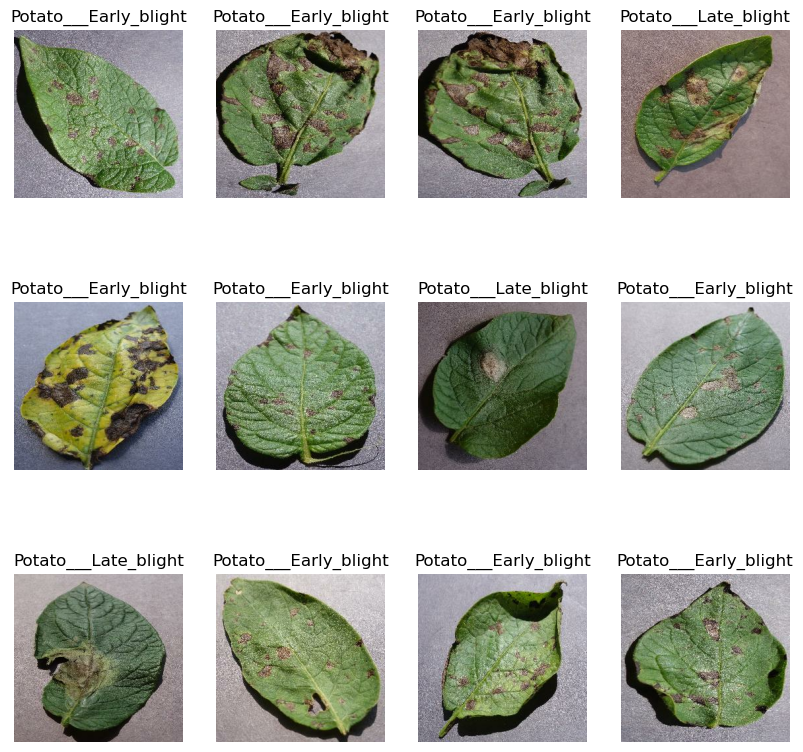

In [74]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [75]:
len(dataset)

68

In [76]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [77]:
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [78]:
train_ds = dataset.take(54)
len(train_ds)


54

In [79]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [80]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [81]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [82]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [83]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)
        
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        
        return train_ds, val_ds, test_ds

In [84]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [85]:
len(train_ds)

54

In [86]:
len(val_ds)

6

In [87]:
len(test_ds)

8

In [88]:
# Cache, Shuffle and Prefetch the data

In [89]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [90]:
# Creating a layer for Resizing and Normalization 

In [91]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [92]:
# Data Augmentation : boost accuracy of data when have less data 

In [93]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [94]:
#Applying Data Augmentation to train dataset

In [95]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [96]:
# Building CNN model through edge detection process 

In [97]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [98]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [99]:
# Compiling the model

In [100]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [101]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)  

Epoch 1/10
54/54 [==============================] - 55s 958ms/step - loss: 0.8867 - accuracy: 0.4751 - val_loss: 0.8430 - val_accuracy: 0.5521
Epoch 2/10
54/54 [==============================] - 54s 994ms/step - loss: 0.6889 - accuracy: 0.6782 - val_loss: 0.7162 - val_accuracy: 0.6510
Epoch 3/10
54/54 [==============================] - 52s 953ms/step - loss: 0.4960 - accuracy: 0.7789 - val_loss: 0.4678 - val_accuracy: 0.8021
Epoch 4/10
54/54 [==============================] - 48s 885ms/step - loss: 0.4433 - accuracy: 0.7998 - val_loss: 0.4428 - val_accuracy: 0.7760
Epoch 5/10
54/54 [==============================] - 50s 925ms/step - loss: 0.3186 - accuracy: 0.8715 - val_loss: 0.2390 - val_accuracy: 0.9010
Epoch 6/10
54/54 [==============================] - 53s 984ms/step - loss: 0.2700 - accuracy: 0.8918 - val_loss: 0.2154 - val_accuracy: 0.8958
Epoch 7/10
54/54 [==============================] - 49s 902ms/step - loss: 0.2344 - accuracy: 0.9167 - val_loss: 0.4388 - val_accuracy: 0.8125

In [103]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 212ms/step - loss: 0.1125 - accuracy: 0.9570


In [104]:
# accurate result of the model

In [105]:
scores

[0.11247776448726654, 0.95703125]

In [106]:
history 



In [107]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [108]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [109]:
history.history['loss'] # Shows loss of accuracy in each epoch 

[0.8867255449295044,
 0.6888887882232666,
 0.4959533214569092,
 0.4432556629180908,
 0.3185558617115021,
 0.2700413167476654,
 0.23437167704105377,
 0.2261415421962738,
 0.12457603216171265,
 0.14796994626522064]

In [110]:
history.history['accuracy'] # shows accuracy of each epoch 

[0.47511574625968933,
 0.6782407164573669,
 0.7789351940155029,
 0.7997685074806213,
 0.8715277910232544,
 0.8917824029922485,
 0.9166666865348816,
 0.9085648059844971,
 0.9519675970077515,
 0.9461805820465088]

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


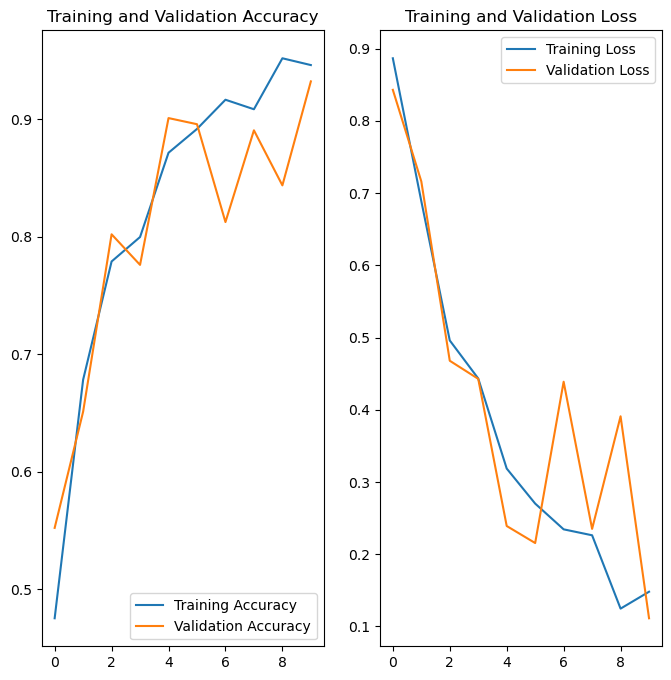

In [112]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 233ms/step
predicted label: Potato___Late_blight


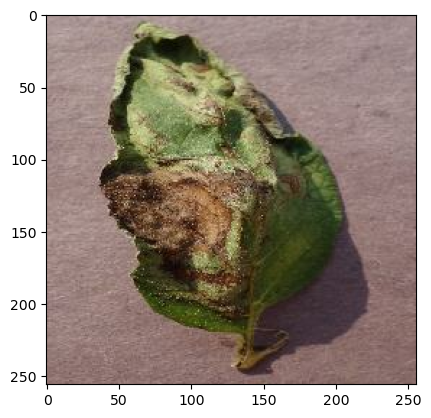

In [116]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [117]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


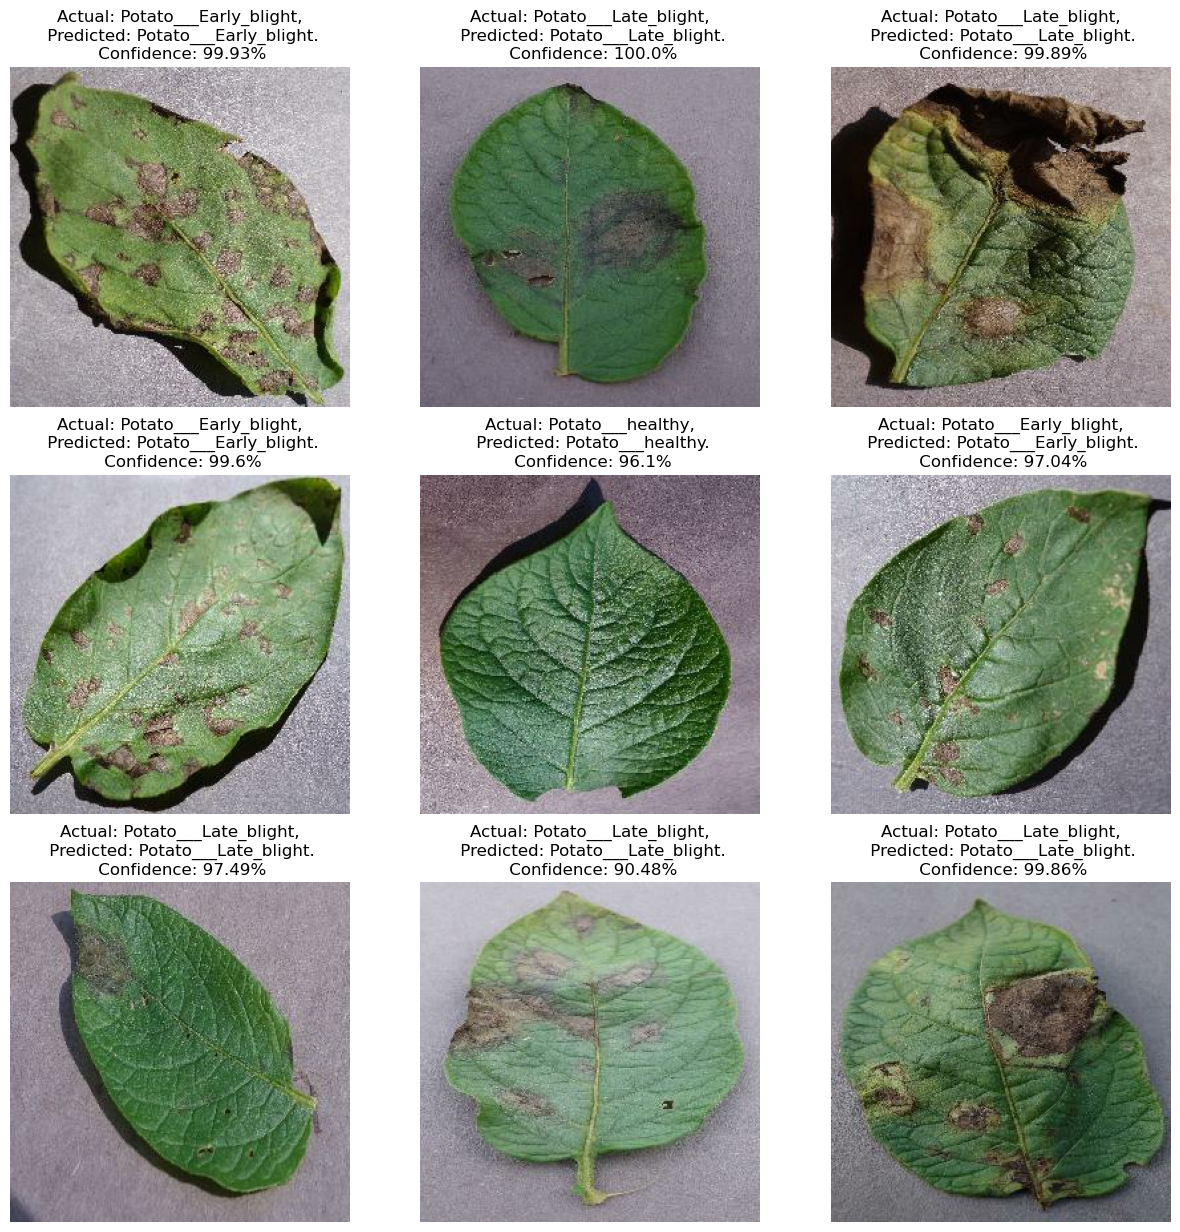

In [118]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [120]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [ ]:
model.save("../potatoes.h5")